# **Modelo v1 | BERT - Classificação de emoção das respostas do Simplício**

## **Link do Projeto no Colab**

---

https://colab.research.google.com/drive/17hC0nIq4Za9Ibk_e8nbCtelmDtwn71eX?usp=sharing

## **Introdução**
---

A classificação de sentimentos é uma tarefa importante em análise de texto, que envolve determinar a opinião ou emoção expressa em um determinado texto. Com o avanço das técnicas de processamento de linguagem natural (NLP) e aprendizado de máquina, tornou-se possível automatizar essa tarefa e extrair informações valiosas de grandes volumes de texto.

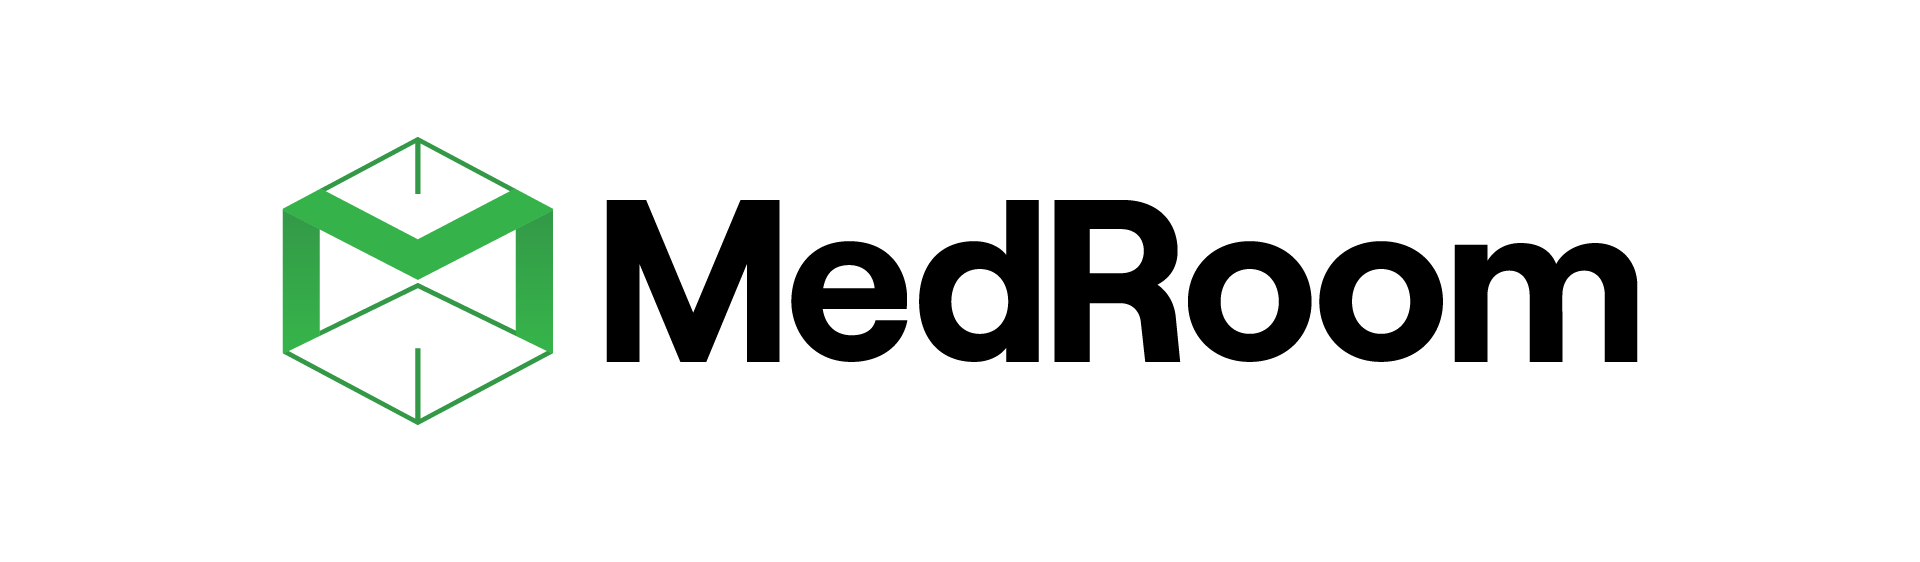

Neste projeto, faremos uso de um conjunto de dados pré-processados composto por respostas do Simplício (Paciente Virtual) que foram rotuladas com os seguintes sentimentos: neutro, medo, raiva, alegria, desgosto, surpresa e tristeza. Empregaremos técnicas de pré-processamento de texto e treinaremos um modelo de classificação de sentimentos utilizando uma arquitetura transformer chamada BERT, que já foi previamente treinada.

## **Sobre os dados**
---

Neste estudo, estaremos utilizando dados obtidos de diálogos entre pessoas reais e nosso modelo de inteligência artificial (Simplício) + Dados gerados manualmente pelo chatGPT + Transcrição da gravação do ator + Anamnesis.

Tudo foi compilado em um único arquivo e no final temos duas colunas:
- **Texto:** Respostas do Simplício
- **Sentimento:** Sentimento das respostas

## **Objetivo**
---

Com base nas informações dispostas nesse conjunto de dados, temos como objetivo:
- Criar um modelo de classificação de emoção/sentimentos das respostas do Simplício

<img src="https://media.giphy.com/media/dQpUkK59l5Imxsh8jN/giphy.gif" alt="win" width="600"/>

## **Preparação dos dados**
---

### **Libs**
---

Primeiro, vamos importar as bibliotecas necessárias:

In [1]:
# Excluir pastas criadas

!rm -r outputs
!rm -r cache_dir
!rm -r runs

In [ ]:
import warnings # Ignorar avisos
warnings.filterwarnings('ignore')
import pandas as pd # Manipulação de dados
import numpy as np # Manipulação de arrays
import seaborn as sns # Gráficos
import matplotlib.pyplot as plt # Gráficos
%matplotlib inline
from sklearn.model_selection import train_test_split # Divisão treino e teste
!pip install simpletransformers # Instalação BERT
from simpletransformers.classification import ClassificationModel, ClassificationArgs # Modelo BERT
!pip install unidecode
from unidecode import unidecode # Remover acentos
import string # Manipulação de strings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score # Métricas de avaliação

### **DataFrame**
---

Em seguida, carregar o DataFrame com os dados:

In [3]:
# Importando dados
df = pd.read_csv('DadosGerados_Simplício_Compilado.csv')

In [4]:
# Visualizando as 10 primeiras linhas do df
df.head(10)

,Texto,Sentimento
0,a alegria de viver continua presente em minha ...,Alegria
1,a alegria é uma parte importante da minha vida,Alegria
2,a alegria está nas pequenas coisas como apreci...,Alegria
3,a caminhada diária tem me deixado mais animado,Alegria
4,a convivência com meus amigos me traz muitas r...,Alegria
5,a dança me faz sentir jovem novamente,Alegria
6,a música do baile sempre alegra o meu dia,Alegria
7,a vida tem seus momentos bons e eu tento aprov...,Alegria
8,acompanhar os passarinhos no quintal é um praz...,Alegria
9,adoro aproveitar os momentos no baile da terce...,Alegria


### **Limpeza e tratamento**
---

Antes de seguirmos com nosso estudo vamos criar uma função que remove pontuações, acentos e deixa as letras minúsculas.

In [5]:
# Criando função que vai tratar nosso texto
def tratar_texto(texto):
    # Remover acentos
    texto_sem_acentos = unidecode(texto)

    # Remover pontuações
    texto_sem_pontuacoes = texto_sem_acentos.translate(str.maketrans("", "", string.punctuation))

    # Converter para letras minúsculas
    texto_tratado = texto_sem_pontuacoes.lower()

    return texto_tratado

In [6]:
# Limpeza e tratamento de dados
df["Texto"] = df.Texto.apply(tratar_texto).astype(str)

# Remove linhas duplicadas
df = df.drop_duplicates()

### **Divisão treino e teste**
---

Vamos dividir os dados em conjuntos de treino, teste e validação. Neste exemplo, usaremos 80% dos dados para treino, 10% para teste e 10% para validação:

In [7]:
# Dividir os dados em treino, teste e validação
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)
val_df, test_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=1)

In [8]:
# Tamanho após divisão
train_df.shape, test_df.shape, val_df.shape

((1154, 2), (145, 2), (144, 2))

## **Modelo BERT v1.0**
---

Agora, vamos definir os hiperparâmetros para o modelo BERT. Utilizaremos a biblioteca **simpletransformers** para facilitar o processo de treinamento. Vamos começar definindo 2 hiperparâmetros na classe **ClassificationArgs**:

- **train_batch_size**: define o tamanho do lote (batch size) utilizado durante o treinamento do modelo. Ele determina quantos exemplos de treinamento são usados em cada passo de atualização dos pesos do modelo.

- **eval_batch_size**: define o tamanho do lote (batch size) utilizado durante a avaliação do modelo em dados de teste. Ele determina quantos exemplos de validação ou teste são processados simultaneamente.

Esses parâmetros afetam a eficiência computacional e o consumo de memória durante o treinamento e avaliação do modelo. Valores maiores para o tamanho do lote podem acelerar o processo de treinamento, mas também exigem mais recursos computacionais. Valores menores podem fornecer uma estimativa mais precisa do desempenho do modelo, mas podem ser mais lentos.

In [9]:
# Classe ClassificationArgs
model_args = ClassificationArgs()
model_args.labels_map = {'Raiva': 0, 'Tristeza': 1, 'Neutro': 2, 'Desgosto': 3, 'Alegria': 4, 'Medo': 5, 'Surpresa': 6}
model_args.num_train_epochs = 5 # Número de epochs
model_args.train_batch_size = 8 # Tamanho do lote treinamento
model_args.eval_batch_size = 8 # Tamanho do lote teste

Agora, vamos criar o modelo de classificação e treiná-lo com os dados de treino.

Estamos usando o modelo pré-treinado **'neuralmind/bert-base-portuguese-cased**', que é uma versão do BERT em português. O parâmetro num_labels é definido como 7, correspondendo aos sentimentos: 'Raiva', 'Tristeza', 'Desgosto', 'Alegria', 'Medo', 'Surpresa' e 'Neutro'.

O parâmetro 'use_cuda=True' significa que estamos utilizando GPU para realizar o treinamento.

In [10]:
model = ClassificationModel(
    'bert',
    'neuralmind/bert-base-portuguese-cased',
    num_labels=7,
    args=model_args,
    use_cuda=True,
)

model.train_model(train_df)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

  0%|          | 0/1154 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/145 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/145 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/145 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/145 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/145 [00:00<?, ?it/s]

(725, 0.32131599311170905)

### **Avaliação 1 | Dados de teste**
---

Agora que o modelo foi treinado, vamos avaliá-lo usando os dados de teste:

In [ ]:
# Redefinir o índice do DataFrame test_df['Texto']
test_df = test_df.reset_index(drop=True)

# Converter os dados da coluna 'Texto' em uma lista de strings
texts = test_df['Texto'].tolist()

# Variável alvo - dados de teste
y_true = test_df['Sentimento']

# Previsões
predictions, raw_outputs = model.predict(texts)

#### **Acurácia**
---

Umas das métricas de avaliação é a "Acurácia", ela diz o quanto o modelo acertou de acordo com as previsões possíveis:

In [12]:
# Acurácia
acc = accuracy_score(y_true, predictions)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 91%


#### **Coeficiente de Correlação de Matthews (MCC)**
---

Essa métrica é usada para avaliar o desempenho geral de um modelo de classificação binária ou multiclasse.

O Coeficiente de Correlação de Matthews varia de -1 a 1, onde 1 representa uma classificação perfeita, 0 indica uma classificação aleatória e -1 indica uma classificação completamente oposta. Portanto, quanto mais próximo o valor de "mcc" estiver de 1, melhor será o desempenho do modelo.

In [13]:
result, model_outputs, wrong_predictions = model.eval_model(test_df)
print("Coeficiente de correlação de matthews = %2.f%%" % (result['mcc'] *100.00))

  0%|          | 0/145 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Coeficiente de correlação de matthews = 90%


#### **Relatório de classificação**
---

Dentre as bibliotecas que importamos existe o "relatório de classificação", nele somos apresentados a mais 3 métricas, são elas:

- *Recall/Sensibilidade*: Medida que nos mostra o quão bom o modelo é para prever/detectar positivos
- *Precisão*: Medida que nos ajuda a responder a seguinte pergunta: Dos classificados como positivos, quantos são realmente positivos?
- *f1-score:* Nos mostra o balanço entre a precisão e o recall de nosso modelo, quanto mais próximo de 1 melhor

In [14]:
# Criando relatório de classificação
def relatorio(y_test,y_pred):
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  # Plotagem do relatório de classificação
  plt.subplots(figsize=(4,3))
  sns.heatmap(report_df, cmap='Greens', linewidths=0.5, annot=True);

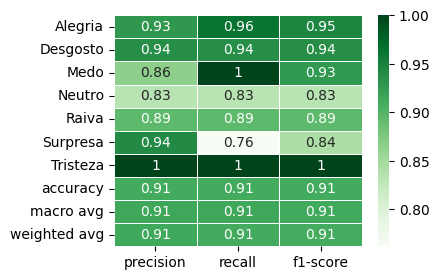

In [15]:
# Plot relatório de classificação
relatorio(y_true,predictions)

#### **Matriz de confusão**
---

A "matriz de confusão" é uma tabela que mostra as frequências de classificação para cada classe do nosso modelo:

In [16]:
def matriz_confusao(y_test,y_pred):

  # Criando a matriz de confusão
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  cnf_report_df = report_df.index[:-3]
  cnf_matrix = confusion_matrix(y_test,y_pred)
  cnf_matrix = pd.DataFrame(cnf_matrix, index = cnf_report_df.values, columns = cnf_report_df.values)
  cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:, np.newaxis] # Normalização em linha (recall)

  # Plotagem da matriz de confusão
  sns.heatmap(cnf_matrix, cmap='Greens', linecolor='white', linewidths=0.5,
            annot=True, fmt='.0%', cbar=False, square=True);

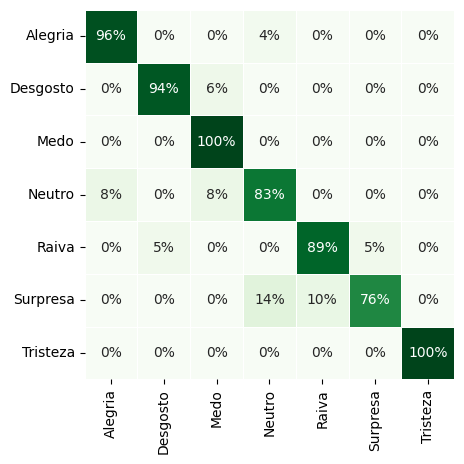

In [17]:
# Plot Matriz de confusão
matriz_confusao(y_true, predictions)

#### **Análise de Overfiting**
---

O overfitting ocorre quando um modelo se ajusta muito bem aos dados de treinamento, mas tem dificuldade em generalizar para dados não vistos anteriormente, como os dados de teste. Vamos analisar como foi o desempenho no treinamento:

In [ ]:
# Redefinir o índice do DataFrame train_df['Texto']
train_df = train_df.reset_index(drop=True)

# Converter os dados da coluna 'Texto' em uma lista de strings
texts = train_df['Texto'].tolist()

# Variável alvo - dados de treino
y_train = train_df['Sentimento']

# Previsões
predictions, raw_outputs = model.predict(texts)

In [19]:
# Acurácia
acc = accuracy_score(y_train, predictions)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 99%


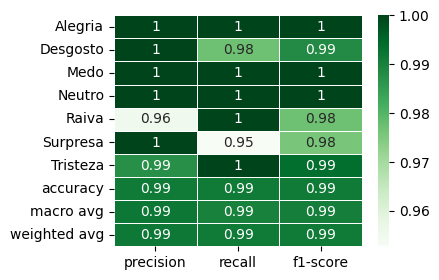

In [20]:
# Plot relatório de classificação
relatorio(y_train,predictions)

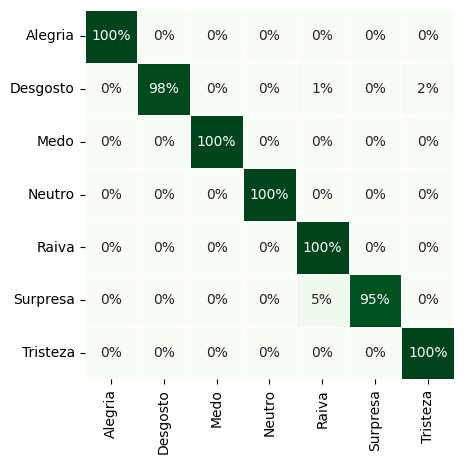

In [21]:
# Plot Matriz de confusão
matriz_confusao(y_train, predictions)

Ao analisar os resultados do relatório de classificação, podemos observar que o desempenho do modelo nos dados de treinamento é quase perfeito, com quase todas as métricas (precisão, recall e F1-score) alcançando o valor máximo de 1.00. Isso indica que o modelo foi capaz de aprender muito bem os padrões presentes nos dados de treinamento.

Também conseguimos notar que a classe 'Surpresa' apresentou resultados inferiores aos demais sentimentos (95%) e na matriz de confusão vimos que o modelo está se confundindo com 'Raiva' (5%).

A acurácia ficou bem próxima dos dados de teste, então levando em conta todos esses cenários, nosso modelo não apresenta indícios de overfiting!

#### **Resumo**
---

Conclusões após avaliação:
- Acurácia = 91%
- MCC = 90%
- F1-Score (média ponderada) ficou em 91%

Resumidamente, tivemos ótimos resultados em nosso primeiro modelo BERT. Todas as métricas estão com valores super positivos com exceção do sentimento 'Surpresa'. Através da matriz de confusão conseguimos notar que 'Surpresa' é o sentimento com menor taxa de acerto (76%) e acabou rolando algumas confusões com sentimento 'Neutro' e 'Raiva'. Nosso modelo também não deu indícios de overfiting.


In [29]:
# Excluir pastas criadas

!rm -r outputs
!rm -r cache_dir
!rm -r runs

## **Modelo BERT v1.1**
---


Agora que geramos nosso primeiro modelo, vamos tentar melhorar nossos resultados mexendo nos hiperparâmetros, para isso vamos usar uma biblioteca chamada 'optuna'

### **Busca de hiperparâmetros**
---

A biblioteca Optuna é uma ferramenta de otimização de hiperparâmetros automatizada. Ela permite a busca automática e eficiente dos melhores hiperparâmetros para um modelo de aprendizado de máquina. Com a Optuna, é possível definir um espaço de busca, escolher uma função objetivo e deixar a biblioteca explorar e encontrar a melhor combinação de hiperparâmetros para maximizar ou minimizar a métrica de interesse.

In [ ]:
!pip install optuna
import optuna

Para essa busca de hiperparâmetros iremos continuar utilizando '**train_batch_size**' e '**eval_batch_size**', mas agora iremos adicionar:

- **learning_rate**: Taxa de aprendizado utilizada durante o treinamento do modelo de aprendizado de máquina. É um valor que controla o tamanho dos ajustes feitos nos pesos do modelo em cada etapa de treinamento. Valores mais altos podem resultar em atualizações mais rápidas, mas podem causar instabilidade. Valores mais baixos podem resultar em treinamento mais lento, mas mais estável.

- **num_train_epochs**: Número de épocas (iterações completas pelo conjunto de treinamento) durante o treinamento do modelo. Cada época percorre o conjunto de treinamento completo. Aumentar o número de épocas pode permitir que o modelo veja mais exemplos de treinamento e melhore sua capacidade de generalização, mas também pode aumentar o tempo de treinamento.

In [30]:
def objective(trial,test_df=test_df):
    # Define os hiperparâmetros a serem otimizados
    model_args = ClassificationArgs()
    model_args.overwrite_output_dir = True
    model_args.labels_map = {'Raiva': 0, 'Tristeza': 1, 'Neutro': 2, 'Desgosto': 3, 'Alegria': 4, 'Medo': 5, 'Surpresa': 6}
    model_args.num_train_epochs = trial.suggest_int("num_train_epochs", 3, 10)
    model_args.train_batch_size = trial.suggest_categorical("train_batch_size", [4, 8, 16])
    model_args.eval_batch_size = trial.suggest_categorical("eval_batch_size", [4, 8, 16])
    model_args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)

    # Cria o modelo com os hiperparâmetros definidos
    model = ClassificationModel(
        "bert",
        "neuralmind/bert-base-portuguese-cased",
        num_labels=7,
        args=model_args,
        use_cuda=True,
    )

    # Treina o modelo com os dados de treinamento
    model.train_model(train_df)

    # Faz previsões no conjunto de teste
    test_texts = test_df["Texto"].tolist()
    test_predictions, _ = model.predict(test_texts)

    # Calcula a métrica a ser otimizada (por exemplo, F1-Score)
    f1 = f1_score(test_df["Sentimento"], test_predictions, average="weighted")
    print("Esse foi o F1-Score: ",f1)

    return f1

In [ ]:
# Criação do estudo do Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Executa 10 iterações de otimização

In [32]:
# Imprime os melhores hiperparâmetros encontrados
best_params = study.best_params
print("Melhores hiperparâmetros encontrados:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Melhores hiperparâmetros encontrados:
num_train_epochs: 3
train_batch_size: 16
eval_batch_size: 8
learning_rate: 5.688040062312472e-05


In [33]:
# Treina o modelo com os melhores hiperparâmetros encontrados
model_args = ClassificationArgs()
model_args.overwrite_output_dir = True
model_args.labels_map = {'Raiva': 0, 'Tristeza': 1, 'Neutro': 2, 'Desgosto': 3, 'Alegria': 4, 'Medo': 5, 'Surpresa': 6}
model_args.num_train_epochs = best_params["num_train_epochs"]
model_args.train_batch_size = best_params["train_batch_size"]
model_args.learning_rate = best_params["learning_rate"]
model_args.eval_batch_size = best_params["eval_batch_size"]

model2 = ClassificationModel(
    "bert",
    "neuralmind/bert-base-portuguese-cased",
    num_labels=7,
    args=model_args,
    use_cuda=True,
)

model2.train_model(train_df)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

  0%|          | 0/1154 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/73 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/73 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/73 [00:00<?, ?it/s]

(219, 0.5846316106787556)

### **Avaliação 2 | Dados de teste**
---


Agora que o modelo foi treinado com os melhores hiperparâmetros, vamos avaliá-lo usando os dados de teste novamente:

In [ ]:
# Redefinir o índice do DataFrame test_df['Texto']
test_df = test_df.reset_index(drop=True)

# Converter os dados da coluna 'Texto' em uma lista de strings
texts = test_df['Texto'].tolist()

# Variável alvo - dados de teste
y_true = test_df['Sentimento']

# Previsões
predictions2, raw_outputs = model2.predict(texts)

#### **Acurácia**
---

In [35]:
# Acurácia
acc2 = accuracy_score(y_true, predictions2)
print("Acurácia do modelo = %2.f%%" % (acc2 *100.00))

Acurácia do modelo = 92%


#### **Coeficiente de Correlação de Matthews (MCC)**
---

In [36]:
result2, model_outputs, wrong_predictions = model2.eval_model(test_df)
print("Coeficiente de correlação de matthews = %2.f%%" % (result2['mcc'] *100.00))

  0%|          | 0/145 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Coeficiente de correlação de matthews = 90%


#### **Relatório de classificação**
---

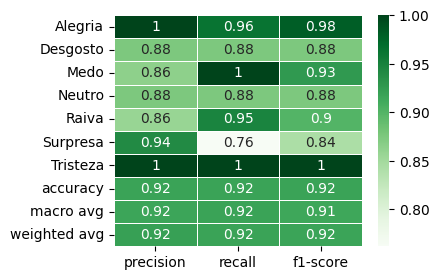

In [37]:
# Plot relatório de classificação
relatorio(y_true,predictions2)

#### **Matriz de confusão**
---

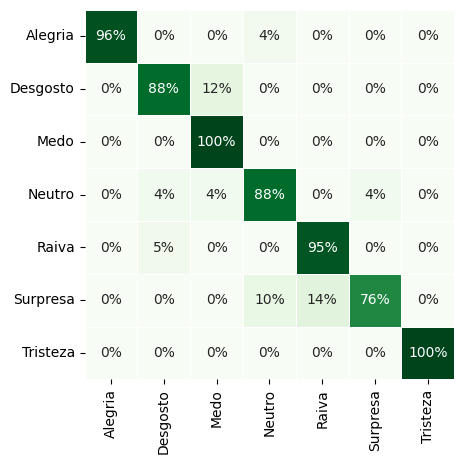

In [38]:
# Plot Matriz de confusão
matriz_confusao(y_true, predictions2)

#### **Resumo**
----

Conclusões após avaliação:
- Acurácia = 92%
- MCC = 90%
- F1-Score (média ponderada) ficou em 92%

Resumidamente, tivemos uma melhora de 1% na acurácia e no F1-Score. Isso porque o modelo aumentou a taxa de acertos em 'Neutro' e 'Raiva'. Em contrapartida diminuiu os acertos em 'Desgosto' e manteve o mesmo percentual em 'Surpresa'.


## **Avaliação | Dados de validação**
---

Agora que temos um modelo otimizado, vamos testar com os dados de validação:

In [ ]:
# Redefinir o índice do DataFrame test_df['Texto']
val_df = val_df.reset_index(drop=True)

# Converter os dados da coluna 'Texto' em uma lista de strings
texts = val_df['Texto'].tolist()

# Variável alvo - dados de teste
y_true_val = val_df['Sentimento']

# Previsões
predictions, raw_outputs = model2.predict(texts)

#### **Acurácia**
---

In [40]:
# Acurácia
acc = accuracy_score(y_true_val, predictions)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 90%


#### **Coeficiente de Correlação de Matthews (MCC)**
---

In [41]:
result2, model_outputs, wrong_predictions = model2.eval_model(val_df)
print("Coeficiente de correlação de matthews = %2.f%%" % (result2['mcc'] *100.00))

  0%|          | 0/144 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

Coeficiente de correlação de matthews = 88%


#### **Relatório de classificação**
---

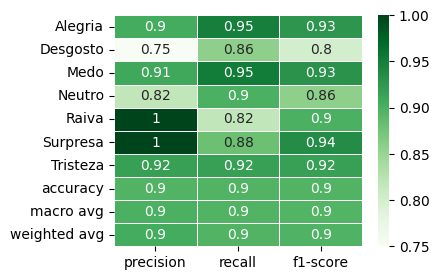

In [42]:
# Plot relatório de classificação
relatorio(y_true_val,predictions)

#### **Matriz de confusão**
---

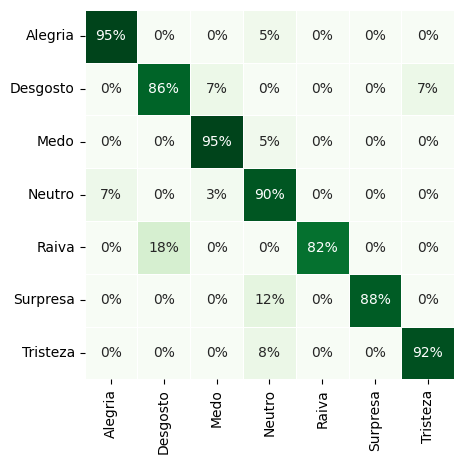

In [43]:
# Plot Matriz de confusão
matriz_confusao(y_true_val, predictions)

#### **Resumo**
----

Conclusões após avaliação:
- Acurácia = 90%
- MCC = 88%
- F1-Score (média ponderada) ficou em 90%

Resumidamente, esses são os resultados nos dados de validação. Podemos dizer que conseguimos criar um bom modelo, otimizamos 4 hiperparâmetros e conseguimos atingir 90% de assertividade. Aqui vale o destaque para as classes 'Alegria', 'Medo' e 'Tristeza'.

Também podemos dizer que nosso modelo não sofreu um overfiting, as métricas de validação estão bem próximas de teste.

Como ponto de atenção ficam as classes 'Surpresa', 'Desgosto' e 'Raiva'. Tivemos uma boa taxa de acerto, porém foram as classes que o modelo mais apresentou confusão, talvez seja bom rever as frases que estão no dataset de treinamento e confirmar se estão atreladas ao sentimento correto.

## **Conclusão**
---

Através deste estudo, quis trazer a criação de um modelo de machine learning, passando por processos de tratamentos de dados, modelagem, otimização, avaliação e por fim a submissão do nosso modelo em dados de teste, a fim de deixar o entendimento mais transparente e direto.

Obviamente, como todos os estudos, este não é uma exceção e poderá ser sempre refinado e sempre estará aberto para novas ideias, feedbacks e ferramentas a serem implementadas.

Nessa etapa testamos mais um algoritmo para nosso sistema de classificação de sentimentos do Simplício. Fizemos 2 versões com uma arquitetura transformer chamada BERT (v1.0; v1.1) e testamos diversas configurações/modificações possíveis no modelo e nos dados.

Resumindo cada versão e resultados em tópicos temos o seguinte:

**v1.0**
- Sem hiperparâmetros
- Acurácia = 91%
- MCC = 90%
- F1-score = 91%

**v1.1**
- Hiperparâmetros
- Acurácia = 92%
- MCC = 90%
- F1-score = 92%

**Dados de validação**
- Modelo v1.1
- Acurácia = 90%
- MCC = 88%
- F1-score = 90%
